# Computed Generated Holography using a Digital Micromirror Device

<a target="_blank" href="https://colab.research.google.com/github/TuragaLab/chromatix/blob/main/docs/examples/dmd.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# If in colab, install Jax and chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install "jax[cuda11_cudnn82]==0.4.1" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install git+https://github.com/TuragaLab/chromatix.git


In this example, we'll demonstrate a version of computer generated holography (CGH) using a digital micromirror device (DMD). We can think of this as optimizing a binary amplitude mask instead of a phase mask, as in the [first CGH example](https://chromatix.readthedocs.io/en/latest/examples/cgh/). Because we will be binarizing the phase, we'll be using a surrogate gradient. All of this is handled in Chromatix automatically. This style of CGH is inspired by the system presented in [[1]](https://doi.org/10.1117/12.2607781), though we demonstrate a much more simplified version of that system.

[[1]](https://doi.org/10.1117/12.2607781): Conference presentation: M. Hossein Eybposh, Aram Moossavi, Vincent R. Curtis, and Nicolas C. Pegard "Optimization of time-multiplexed computer-generated holograms with surrogate gradients", Proc. SPIE PC12014, Emerging Digital Micromirror Device Based Systems and Applications XIV, PC1201406 (9 March 2022); https://doi.org/10.1117/12.2607781.

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from optax import adam
import optax
from chex import Array

from time import time
from typing import Any, Callable, Optional, Sequence, Tuple, Union
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import cat

from chromatix import Field
from chromatix.elements import PlaneWave, PhaseMask, FFLens, AmplitudeMask
from chromatix.systems import OpticalSystem
from chromatix.functional import plane_wave, transfer_propagate
from chromatix.utils import trainable
from flax.training.train_state import TrainState

key = random.PRNGKey(4)

## Creating a 2D natural image target hologram

This is the hologram we'll be trying to recreate using our DMD. This example shows the optimization of a 2D hologram of a natural image. For an example of holography with a (very simple) 3D sample, see the other CGH example.

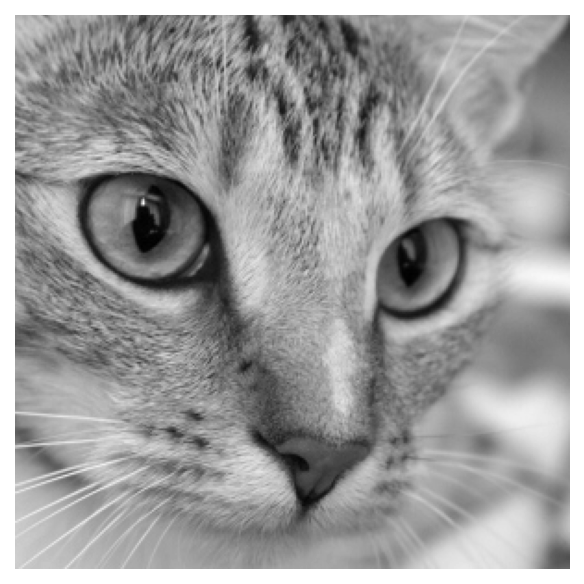

In [2]:
im = cat().mean(2)
im = im[:, 100:400]
data = jnp.array(im)

plt.figure(dpi=150)
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.show()

## Constructing the CGH model with a DMD

We've seen in [other](https://chromatix.readthedocs.io/en/latest/examples/cgh/) [examples](https://chromatix.readthedocs.io/en/latest/examples/holoscope/) that defining optical systems is straightforward in Chromatix. Here, we show a CGH system that uses a new element, the `AmplitudeMask`. The `AmplitudeMask` can optionally be binarized, which means that the amplitudes will be squashed to either a 1 or a 0, and gradients through the binarization will be computed using the surrogate gradient method (as if no transformation has been applied to the amplitude mask).

In this version of the CGH model, we'll also demonstrate how to build a model that can propagate to different distances by taking the z value as an argument. We lose the ability to cache the propagation kernel, which means that we have to do a little bit of extra work on every call to the model. However, for the simple propagation we are going to do here, this is no problem.

In [3]:
class CGH(nn.Module):
    amplitude_init: Callable = lambda key, grid: jax.nn.initializers.uniform(1.5)(key, grid.shape[1:])
    shape: Tuple[int, int] = (300, 300)
    spacing: float = 7.56
    f: float = 200.0
    n: float = 1.0
    NA: Optional[float] = None
    N_pad: int = 0
    spectrum: Array = 0.66
    spectral_density: Array = 1.0
    
    @nn.compact
    def __call__(self, z: Union[float, Array]) -> Field:
        # Chromatix does the work of simulating the propagation of the plane wave into
        # the desired hologram at multiple depths. This lets us define a CGH simulation
        # in just a few lines.
        system = OpticalSystem([
            PlaneWave(
                shape=self.shape,
                dx=self.spacing,
                spectrum=self.spectrum,
                spectral_density=self.spectral_density
            ),
            AmplitudeMask(trainable(self.amplitude_init), is_binary=True)
        ])
        # We use the functional transfer_propagate which uses the z argument,
        # instead of fixing the z value using the Propagate element like in
        # the first CGH example. This lets us compute the propagation to any
        # z at runtime, instead of caching the propagation distance and kernel
        # in the Propagate element.
        return transfer_propagate(system(), z, self.n, self.N_pad)

In [4]:
z = 13e4
model = CGH()
variables = model.init(key, z)

# Split into two
params, state = variables["params"], variables["state"]
del variables # delete for memory

## Optimizing the CGH system

We've discussed how to optimize a system in Chromatix using Flax and Optax in the [first CGH example](https://chromatix.readthedocs.io/en/latest/examples/cgh/), so we won't detail those things here. The training setup and loop is basically the same, so we'll just go through the whole training process here:

In [5]:
def loss_fn(params, state, data, z):
    eps = 1e-6
    approx = model.apply({"params": params, "state": state}, z=z).intensity.squeeze() 
    loss = optax.cosine_distance(predictions=approx.reshape(-1), targets=data.reshape(-1), epsilon=eps).mean()
    correlation = jnp.sum(approx * data) / (jnp.sqrt(jnp.sum(approx**2) * jnp.sum(data**2)) + eps)
    return loss, {"loss": loss, "correlation": correlation}

In [6]:
# Setting the state which has the model, params and optimiser
trainstate = TrainState.create(apply_fn=model.apply, 
                          params=params, 
                          tx=optax.adam(learning_rate=2))

# Defining the function which returns the gradients
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True))

In [7]:
%%time
# Simple training loop
max_iterations = 400
history = {"loss": np.zeros((max_iterations)), "correlation": np.zeros((max_iterations))}
for iteration in range(max_iterations):
    grads, metrics = grad_fn(trainstate.params, state, data, z) 
    trainstate = trainstate.apply_gradients(grads=grads)

    for m in metrics:
        history[m][iteration] = metrics[m]
    if iteration % 40 == 0 or iteration == (max_iterations - 1):
        print(iteration, metrics)
        approx1 = trainstate.apply_fn({"params": trainstate.params, "state": state}, z=z).intensity.squeeze() 

0 {'correlation': Array(0.7724121, dtype=float32), 'loss': Array(0.22758782, dtype=float32)}
40 {'correlation': Array(0.9109794, dtype=float32), 'loss': Array(0.08902061, dtype=float32)}
80 {'correlation': Array(0.9131217, dtype=float32), 'loss': Array(0.086878, dtype=float32)}
120 {'correlation': Array(0.91501296, dtype=float32), 'loss': Array(0.08498687, dtype=float32)}
160 {'correlation': Array(0.9164945, dtype=float32), 'loss': Array(0.08350539, dtype=float32)}
200 {'correlation': Array(0.9174329, dtype=float32), 'loss': Array(0.08256698, dtype=float32)}
240 {'correlation': Array(0.9182609, dtype=float32), 'loss': Array(0.08173931, dtype=float32)}
280 {'correlation': Array(0.9192862, dtype=float32), 'loss': Array(0.08071363, dtype=float32)}
320 {'correlation': Array(0.92021805, dtype=float32), 'loss': Array(0.07978183, dtype=float32)}
360 {'correlation': Array(0.92081225, dtype=float32), 'loss': Array(0.07918733, dtype=float32)}
399 {'correlation': Array(0.9215415, dtype=float32), 

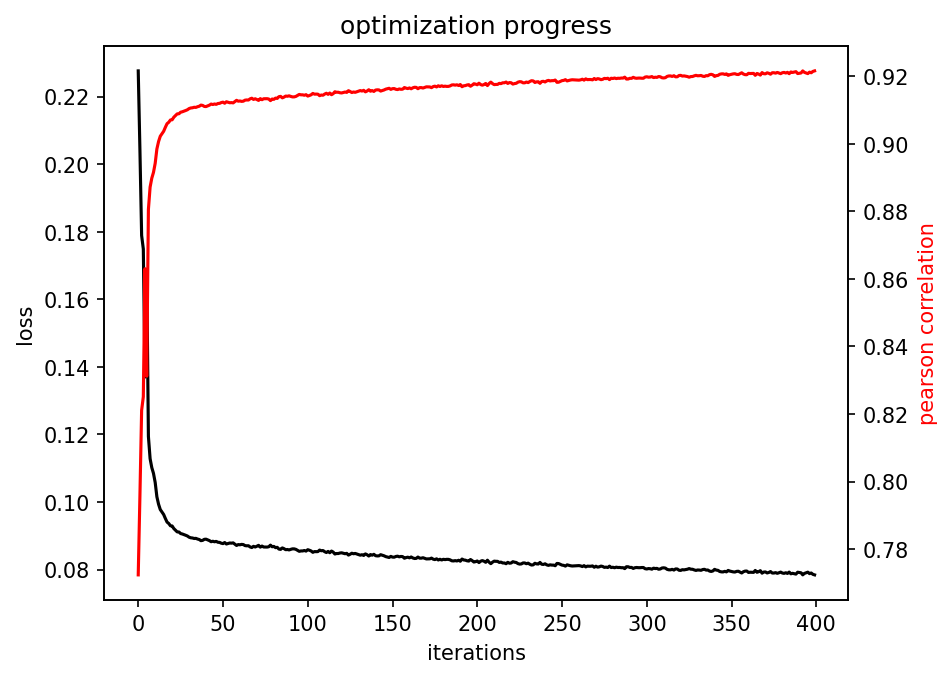

In [8]:
fig, ax1 = plt.subplots(dpi=150)

ax1.plot(np.array(history["loss"]), color="black")
ax1.set_ylabel("loss")
ax1.set_xlabel("iterations")
ax2 = ax1.twinx()

ax2.plot(np.array(history["correlation"]), color="red")
ax2.set_ylabel("pearson correlation", color="red")
plt.title("optimization progress")
plt.show()

## Evaluation

Let's have a look at how we did! We'll look at what happens when we apply our binarized amplitude mask to a plane wave and then propagate to the desired distance. We can also take a look at the optimized amplitude mask and its binarized form, which is the pattern we would see on the DMD.

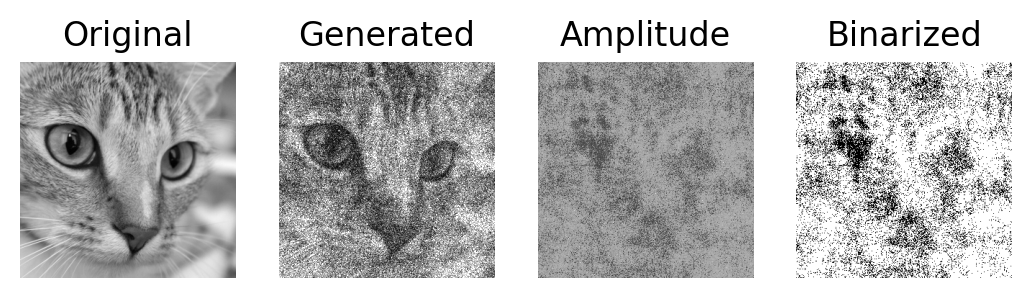

In [9]:
plt.figure(dpi=200)
plt.subplot(1, 4, 1)
plt.axis("off")
plt.imshow(data, cmap='gray')
plt.title('Original')

plt.subplot(1, 4, 2)
plt.imshow(approx1, vmax=np.percentile(approx1, 95), cmap='gray')
plt.title('Generated')
plt.axis("off")

plt.subplot(1, 4, 3)
amp = trainstate.params['AmplitudeMask_0']['_amplitude'].squeeze()
plt.imshow(amp, cmap='gray')
plt.title('Amplitude')
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(np.float32(amp > 0.5), cmap='gray')
plt.title('Binarized')
plt.axis("off")
plt.show()

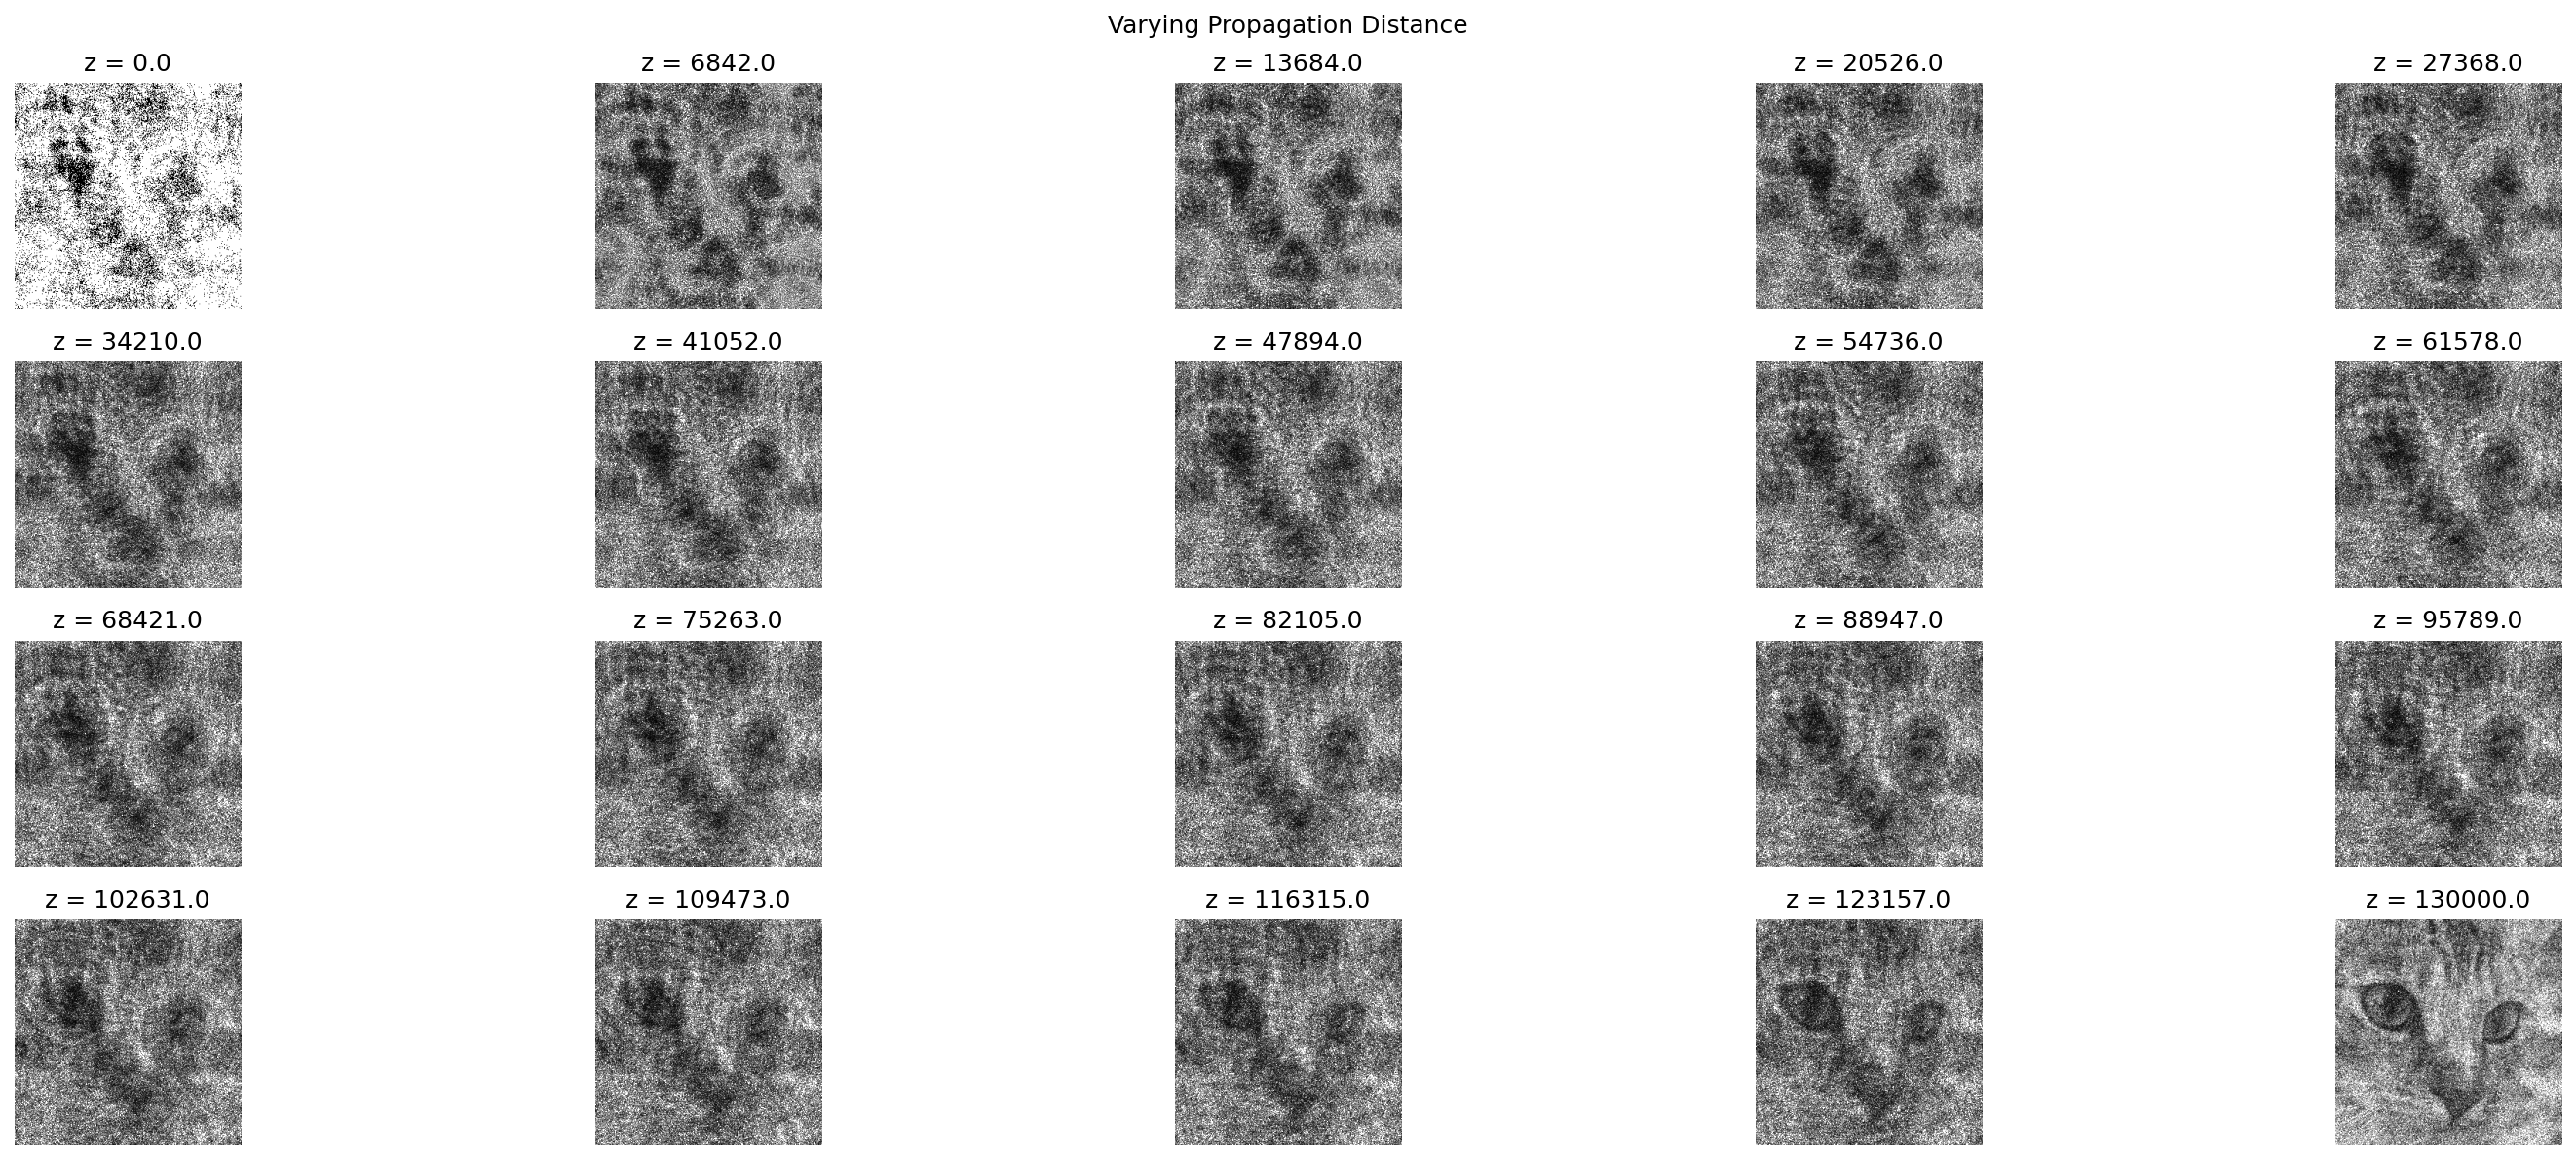

In [10]:
z_list = np.linspace(0., z, 20)
images = model.apply({"params":trainstate.params, "state": state}, z=z_list).intensity.squeeze() 

plt.figure(figsize=(20,10), dpi=150)
plt.suptitle("Varying Propagation Distance")

columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image, vmax=np.percentile(image, 95), cmap='gray')
    plt.axis("off")    
    plt.title(f'z = {z_list[i].squeeze()//1}') 
plt.tight_layout()

We can also look at what happens along the propagation path by propagating to intermediate distances. This reveals the image of the cat forming as we get closer and closer to the target propagation distance. We can see that in the end we produced a hologram pretty close to the target image, though we have a lot of noise in the hologram! We'll leave fixing that as another exercise to the reader.